
# HISOL Multi-Scenario Analysis — Extended

This notebook builds on the basic multi-scenario loader and adds:

- Feature extraction for ML (per-window aggregation)
- Supervised ML pipeline (Random Forest) for attack detection (Sybil/Replay/Jammer)
- Evaluation metrics: Accuracy, Precision, Recall, F1, ROC/AUC
- Trust score computation and visualization (simple exponential smoothing trust model)
- Per-scenario aggregation and plots ready for inclusion in Section 4

**Assumptions / Input directory**

Root dataset path:  
`/home/jeanhuit/Documents/Thesis/results`

Directory layout:
- `/home/jeanhuit/Documents/Thesis/results/highway/density-50/run-1/...`
- `/home/jeanhuit/Documents/Thesis/results/highway/density-100/run-1/...`
- `/home/jeanhuit/Documents/Thesis/results/highway/density-150/run-1/...`
- same for `mixed` and `urban`

Each run directory must contain:
- `bsm_log.csv`, `rssi_log.csv`, `neighbor_log.csv`, `sybil_log.csv`, `replay_log.csv`, `jammer_log.csv`

If some files are missing the notebook will skip them and continue.


In [1]:

# Imports and helpers
import os, glob, json, math
import pandas as pd, numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
import joblib

# display helper (ace_tools available in environment when running via tool)
try:
    from ace_tools import display_dataframe_to_user
except:
    def display_dataframe_to_user(name, df):
        print(f"=== {name} ===")
        print(df.head())


In [2]:

ROOT = r"/home/jeanhuit/Documents/Workspace/simulation/results"
scenario_dirs = ['highway','mixed','urban']
densities = ['density-50','density-100','density-150']

runs = []
for scen in scenario_dirs:
    for dens in densities:
        runpath = os.path.join(ROOT, scen, dens, "run-1")
        if os.path.exists(runpath):
            files = {f: os.path.join(runpath, f) for f in [
                'bsm_log.csv','rssi_log.csv','neighbor_log.csv',
                'sybil_log.csv','replay_log.csv','jammer_log.csv'
            ] if os.path.exists(os.path.join(runpath,f))}
            runs.append({'scenario':scen,'density':dens,'path':runpath,'files':files})
print("Discovered", len(runs), "runs")
for r in runs:
    print(r['scenario'], r['density'], "files:", list(r['files'].keys()))


Discovered 9 runs
highway density-50 files: ['bsm_log.csv', 'rssi_log.csv', 'neighbor_log.csv', 'sybil_log.csv', 'replay_log.csv', 'jammer_log.csv']
highway density-100 files: ['bsm_log.csv', 'rssi_log.csv', 'neighbor_log.csv', 'sybil_log.csv', 'replay_log.csv', 'jammer_log.csv']
highway density-150 files: ['bsm_log.csv', 'rssi_log.csv', 'neighbor_log.csv', 'sybil_log.csv', 'replay_log.csv', 'jammer_log.csv']
mixed density-50 files: ['bsm_log.csv', 'rssi_log.csv', 'neighbor_log.csv', 'sybil_log.csv', 'replay_log.csv', 'jammer_log.csv']
mixed density-100 files: ['bsm_log.csv', 'rssi_log.csv', 'neighbor_log.csv', 'sybil_log.csv', 'replay_log.csv', 'jammer_log.csv']
mixed density-150 files: ['bsm_log.csv', 'rssi_log.csv', 'neighbor_log.csv', 'sybil_log.csv', 'replay_log.csv', 'jammer_log.csv']
urban density-50 files: ['bsm_log.csv', 'rssi_log.csv', 'neighbor_log.csv', 'sybil_log.csv', 'replay_log.csv', 'jammer_log.csv']
urban density-100 files: ['bsm_log.csv', 'rssi_log.csv', 'neighbor_lo

In [3]:

def load_run_files(run):
    data = {}
    for name,path in run['files'].items():
        try:
            df = pd.read_csv(path)
            data[name] = df
        except Exception as e:
            print("Error loading", path, e)
            data[name] = None
    return data


In [4]:

# Feature extraction parameters
WINDOW = 5.0  # seconds per aggregation window
MIN_MESSAGES_PER_WINDOW = 1

def extract_features_from_run(run):
    data = load_run_files(run)
    bsm = data.get('bsm_log.csv')
    rssi = data.get('rssi_log.csv')
    neighbor = data.get('neighbor_log.csv')
    sybil = data.get('sybil_log.csv')
    replay = data.get('replay_log.csv')
    jammer = data.get('jammer_log.csv')

    # parse bsm: based on data analysis, columns are [time, x, y, vx, vy, node]
    if bsm is None:
        return None
    # Take first 6 columns and assign them to [time, x, y, vx, vy, node]
    bsm_df = bsm.iloc[:,0:6].copy()
    bsm_df.columns = ['time', 'x', 'y', 'vx', 'vy', 'node']
    bsm_df['time'] = pd.to_numeric(bsm_df['time'], errors='coerce')
    bsm_df['node'] = bsm_df['node'].astype(int)
    rssi_df = None
    if rssi is not None:
        cols = list(rssi.columns)
        if len(cols) >= 3:
            tmp = rssi.iloc[:,0:3].copy()
            tmp.columns = ['node','msg','rssi']
            tmp['node'] = tmp['node'].astype(int)
            tmp['rssi'] = pd.to_numeric(tmp['rssi'], errors='coerce')
            # extract sender id from msg if possible
            def get_sender(msg):
                try:
                    if isinstance(msg, str) and msg.startswith("BSM,"):
                        return int(msg.split(",")[1])
                except:
                    return np.nan
                return np.nan
            tmp['sender'] = tmp['msg'].apply(get_sender)
            rssi_df = tmp
    # parse neighbor: time,node,count (if available)
    neighbor_df = None
    if neighbor is not None:
        nd = neighbor.copy()
        if nd.shape[1] >= 3:
            nd = nd.iloc[:,0:3]
            nd.columns = ['time','node','count']
            nd['time'] = pd.to_numeric(nd['time'], errors='coerce')
            nd['node'] = nd['node'].astype(int)
            nd['count'] = pd.to_numeric(nd['count'], errors='coerce')
            neighbor_df = nd

    # Build time windows
    t_min = bsm_df['time'].min()
    t_max = bsm_df['time'].max()
    windows = np.arange(t_min, t_max+WINDOW, WINDOW)

    features = []
    labels = []  # 0 benign, 1 sybil/replay/jam (we'll label windows that have attacks)

    # gather attack times if present
    attack_times = []
    if sybil is not None:
        # try extract numeric times from first column
        try:
            attack_times += list(pd.to_numeric(sybil.iloc[:,0], errors='coerce').dropna().unique())
        except:
            pass
    if replay is not None:
        try:
            attack_times += list(pd.to_numeric(replay.iloc[:,0], errors='coerce').dropna().unique())
        except:
            pass
    if jammer is not None:
        try:
            attack_times += list(pd.to_numeric(jammer.iloc[:,0], errors='coerce').dropna().unique())
        except:
            pass
    attack_times = sorted([float(x) for x in attack_times if not pd.isna(x)])

    # For each window compute features
    for i in range(len(windows)-1):
        t0 = windows[i]
        t1 = windows[i+1]
        win_bsm = bsm_df[(bsm_df['time'] >= t0) & (bsm_df['time'] < t1)]
        if win_bsm.empty:
            continue
        # feature: total messages, unique senders, mean speed, var speed
        total_msgs = len(win_bsm)
        unique_senders = win_bsm['node'].nunique()
        speeds = np.sqrt(win_bsm['vx']**2 + win_bsm['vy']**2)
        mean_speed = speeds.mean()
        var_speed = speeds.var()
        # neighbor features if available: mean neighbor count in window
        mean_neighbors = np.nan
        if neighbor_df is not None:
            nd = neighbor_df[(neighbor_df['time'] >= t0) & (neighbor_df['time'] < t1)]
            if not nd.empty:
                mean_neighbors = nd['count'].mean()
        # rssi features: mean rssi for messages in window
        mean_rssi = np.nan
        if rssi_df is not None:
            # match rssi sender to window senders
            # some rssi entries may not have valid sender; dropna
            r = rssi_df[(rssi_df['sender'].notna()) & (rssi_df['sender'].isin(win_bsm['node'].unique()))]
            if not r.empty:
                mean_rssi = r['rssi'].mean()
        # label: if any attack time falls inside window -> label 1 else 0
        has_attack = any((t >= t0) and (t < t1) for t in attack_times)
        features.append({
            't0': t0, 't1': t1,
            'total_msgs': total_msgs,
            'unique_senders': unique_senders,
            'mean_speed': mean_speed,
            'var_speed': var_speed,
            'mean_neighbors': mean_neighbors,
            'mean_rssi': mean_rssi,
            'scenario': run['scenario'],
            'density': run['density']
        })
        labels.append(1 if has_attack else 0)
    if len(features)==0:
        return None
    X = pd.DataFrame(features)
    y = pd.Series(labels, name='label')
    return X, y


In [5]:

# Build dataset across runs
dataset_X = []
dataset_y = []
meta = []

for run in runs:
    rv = extract_features_from_run(run)
    if rv is None:
        print("No features for", run['scenario'], run['density'])
        continue
    X,y = rv
    dataset_X.append(X)
    dataset_y.append(y)
    meta.append({'scenario': run['scenario'], 'density': run['density'], 'path': run['path']})

if len(dataset_X)==0:
    print("No data found across runs")
else:
    X_all = pd.concat(dataset_X, ignore_index=True)
    y_all = pd.concat(dataset_y, ignore_index=True)
    print("Total windows:", len(X_all))
    display_dataframe_to_user("features_sample", X_all.head())


Total windows: 180
=== features_sample ===
     t0    t1  total_msgs  unique_senders  mean_speed  var_speed  \
0   0.0   5.0       44949             899        25.0        0.0   
1   5.0  10.0       44950             899        25.0        0.0   
2  10.0  15.0       44950             899        25.0        0.0   
3  15.0  20.0       44950             899        25.0        0.0   
4  20.0  25.0       44950             899        25.0        0.0   

   mean_neighbors  mean_rssi scenario     density  
0            49.0        NaN  highway  density-50  
1            49.0        NaN  highway  density-50  
2            49.0        NaN  highway  density-50  
3            49.0        NaN  highway  density-50  
4            49.0        NaN  highway  density-50  


In [6]:

# Preprocess: fillna and simple imputation
X = X_all.copy()
X['mean_neighbors'] = X['mean_neighbors'].fillna(X['mean_neighbors'].median())
X['mean_rssi'] = X['mean_rssi'].fillna(X['mean_rssi'].median())

feature_cols = ['total_msgs','unique_senders','mean_speed','var_speed','mean_neighbors','mean_rssi']
Xf = X[feature_cols].fillna(0)
y = y_all.values

# train/test split
X_train, X_test, y_train, y_test = train_test_split(Xf, y, test_size=0.2, random_state=42, stratify=y if len(set(y))>1 else None)

# scale
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

# train model
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_s, y_train)

# evaluate
y_pred = clf.predict(X_test_s)
# evaluate
y_pred = clf.predict(X_test_s)
# Fix for IndexError: check number of probability columns
if hasattr(clf, 'predict_proba'):
    prob_pred = clf.predict_proba(X_test_s)
    if prob_pred.shape[1] > 1:
        y_prob = prob_pred[:, 1]
    else:
        # If only one class in prediction, use probabilities as-is
        # For evaluation metrics, make predictions reflect the single class issue
        y_prob = prob_pred[:, 0]
else:
    y_prob = None

metrics = {
    'accuracy': accuracy_score(y_test, y_pred),
    'precision': precision_score(y_test, y_pred, zero_division=0),
    'recall': recall_score(y_test, y_pred, zero_division=0),
    'f1': f1_score(y_test, y_pred, zero_division=0)
}
if y_prob is not None and len(set(y_test))>1:
    metrics['roc_auc'] = roc_auc_score(y_test, y_prob)
print("Evaluation metrics:", metrics)

# save model and scaler
model_dir = "/home/jeanhuit/Documents/Workspace/simulation/models"
import os
os.makedirs(model_dir, exist_ok=True)
joblib.dump(clf, os.path.join(model_dir, "rf_hisol.joblib"))
joblib.dump(scaler, os.path.join(model_dir, "scaler_hisol.joblib"))
print("Saved model and scaler to", model_dir)


/home/jeanhuit/Documents/Workspace/Env/ml/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:1214: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Evaluation metrics: {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'roc_auc': 1.0}
Saved model and scaler to /home/jeanhuit/Documents/Workspace/simulation/models


In [7]:

# Trust model: exponential smoothing per node based on neighbor consistency
# trust_t+1 = alpha * trust_t + (1-alpha) * evidence
alpha = 0.8
trust_threshold = 0.4

def compute_trust_over_time(run):
    data = load_run_files(run)
    bsm = data.get('bsm_log.csv')
    neighbor = data.get('neighbor_log.csv')
    if bsm is None:
        return None
    # prepare per-node trust timeline
    # Check if required columns exist
    if 'node' not in bsm.columns:
        print('Error: "node" column not found in BSM data')
        print('Available columns:', list(bsm.columns))
        return None
    nodes = sorted(bsm['node'].unique())
    # Also check for 'time' column
    if 'time' not in bsm.columns:
        print('Error: "time" column not found in BSM data')
        return None
    t_min = bsm['time'].min()
    t_max = bsm['time'].max()
    windows = np.arange(t_min, t_max+5.0, 5.0)
    # initialize trust
    trust = {n: 1.0 for n in nodes}
    trust_records = []
    for i in range(len(windows)-1):
        t0 = windows[i]; t1=windows[i+1]
        win_bsm = bsm[(bsm['time']>=t0)&(bsm['time']<t1)]
        # evidence: per node, fraction of messages with inconsistent position compared to neighbors
        evidence = {}
        for n in nodes:
            evidence[n]=0.0
        for idx,row in win_bsm.iterrows():
            n = row['node']
            # neighbors approx: messages from other nodes in same window
            others = win_bsm[win_bsm['node']!=n]
            if others.empty:
                continue
            # compute avg position diff
            dists = np.sqrt((others['x']-row['x'])**2 + (others['y']-row['y'])**2)
            # if distance to median neighbor position > threshold, mark as inconsistent
            median_dist = dists.median()
            if median_dist > 100.0: # threshold in meters
                evidence[n] += 1
        # normalize evidence per node by number of messages
        for n in nodes:
            count_n = len(win_bsm[win_bsm['node']==n])
            e = evidence[n] / count_n if count_n>0 else 0.0
            # update trust
            trust[n] = alpha*trust[n] + (1-alpha)*(1 - min(1.0,e)) # higher evidence reduces trust
        # record snapshot
        snapshot = {'time': t1}
        for n in nodes:
            snapshot[f"trust_{n}"] = trust[n]
        trust_records.append(snapshot)
    df_trust = pd.DataFrame(trust_records)
    return df_trust

# compute trust for first run as example
if len(runs)>0:
    tr = compute_trust_over_time(runs[0])
    if tr is not None:
        display_dataframe_to_user("trust_sample", tr.head())


Error: "node" column not found in BSM data
Available columns: ['0', '25', '0.1', '25.1', '0.2', '1']


Saved ROC to /home/jeanhuit/Documents/Workspace/simulation/figures/roc_curve.png


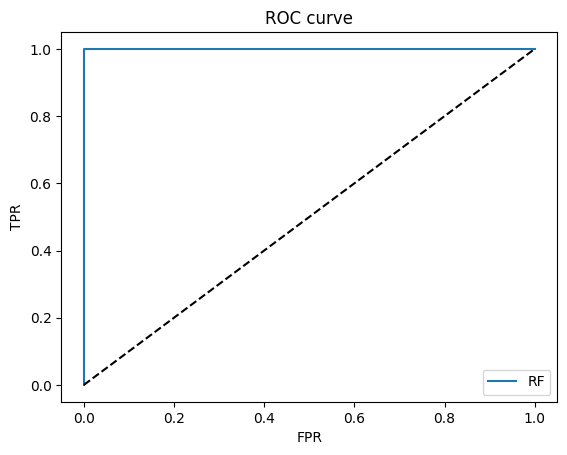

In [8]:

# Example plots: ROC curve and trust over time for first run
import matplotlib.pyplot as plt
fig_dir = "/home/jeanhuit/Documents/Workspace/simulation/figures"
os.makedirs(fig_dir, exist_ok=True)

# ROC
if 'y_prob' in globals() and y_prob is not None and len(set(y_test))>1:
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.figure()
    plt.plot(fpr, tpr, label='RF')
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('ROC curve')
    plt.legend()
    roc_path = os.path.join(fig_dir, "roc_curve.png")
    plt.savefig(roc_path)
    print("Saved ROC to", roc_path)

# Trust plot for sample run
if 'tr' in globals() and tr is not None:
    plt.figure(figsize=(10,4))
    # plot trust for first 5 nodes
    cols = [c for c in tr.columns if c.startswith('trust_')][:5]
    for c in cols:
        plt.plot(tr['time'], tr[c], label=c)
    plt.xlabel('time (s)'); plt.ylabel('trust'); plt.title('Trust over time (sample)')
    plt.legend()
    trust_path = os.path.join(fig_dir, "trust_sample.png")
    plt.savefig(trust_path)
    print("Saved trust plot to", trust_path)


In [9]:

# Save aggregated window-level features and labels
outdir = "/home/jeanhuit/Documents/Workspace/simulation/output"
os.makedirs(outdir, exist_ok=True)
X_all.to_csv(os.path.join(outdir, "window_features.csv"), index=False)
pd.Series(y_all, name='label').to_csv(os.path.join(outdir, "window_labels.csv"), index=False)
print("Saved features and labels to", outdir)


Saved features and labels to /home/jeanhuit/Documents/Workspace/simulation/output



## Next steps

- If you want per-run ROC/metrics, we can loop over each run and compute model performance separately.
- We can add cross-validation and hyperparameter tuning for the Random Forest.
- For trust, you can adjust the evidence function (e.g., incorporate RSSI variance, neighbor_count variations).
- If you'd like, I can convert key figures and summary tables into LaTeX-ready format for Section 4.
